It is recommended that you read this in Colab, even if you don't run it, so that the boring cells are collapsed

<a target="_blank" href="https://colab.research.google.com/github/Computational-physics-with-learning/PINNs/blob/main/PINNS.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [8]:
#@title Import packages and download data
%%capture
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/code/utils.py
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/code/torch_utils.py
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/data/image_0001.jpg
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/data/models.7z
!wget -nc https://github.com/Computational-physics-with-learning/PINNs/raw/main/data/PINN_performance.7z

!7z x -aos models.7z -omodels
!7z x -aos PINN_performance.7z -omodels

from utils import (np, plt, makedir, os, tqdm,
    splitPoints, plotcompare2d, examples2D)
from torch_utils import (pt, time, str2loss, DenseNN, Basic_model, 
    to_device, from_device, plotHistory)
from numba import jit, prange
from PIL import Image, ImageOps
myImg = Image.open('image_0001.jpg')
myImg = np.array(ImageOps.grayscale(myImg))
myImg = np.pad(myImg,5) / myImg.max()

# makedir(os.path.join('models','PINN',''))

import shutil
try:
    shutil.rmtree('sample_data') # bloody waste of space
except FileNotFoundError:
    pass

# Intro to PINNs
Main reference is a very detailed review: https://arxiv.org/pdf/2201.05624.pdf

We assume we are given a 'physical' inverse problem,
$$ \text{find } u\colon \mathbb R^d\to \mathbb R \text{ such that } \forall x\in \Omega_{points},\ u(x) = g(x)\quad\text{and}\quad \forall x\in\Omega_{constraint},\ F(x, u) = 0.$$
Typical PDE examples:
- Heat equation: &emsp;&nbsp;&nbsp;&nbsp;&nbsp; $u(0,x) = g(x)$, $u(t,0)=u(t,1)=0$ for all $t,x\in[0,1]$ and &emsp; $\partial_t u - \partial_{xx} u = 0$
- Advection equation: $u(t,x) = g(t,x)$ on $\Omega_{points} \subset \partial([0,1]^2)$, and &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; $\partial_t u + \partial_x u = 0$
- Burger's equation: &nbsp;&nbsp;&nbsp;&nbsp;$u(0,x) = g(x)$, $u(t,0)=u(t,1)=0$ for all $t,x\in[0,1]$ and &emsp;$\partial_t u + u\partial_x u - \partial_{xx} u = 0$

Examples with Neumann boundary etc are possible but we'll ignore them for simplicity.

By a Physics-Informed Neural Network (PINN) we mean choosing a parametrisation $u = u_\theta$ to be a neural network, as opposed to a classical finite difference/element representation.  
The motivation for this:
- NNs have been found to be very efficicient at approximating very complicated functions
  - Maybe deep NNs overcome curse of dimensionality?
- Derivatives of $u_\theta$ can be computed via automatic differentiation, trivial to implement through ML packages
- Complicated PDEs can be implemented with low additional complexity (still results in non-convex optimisation problem)
  - If PDE is $\partial_t u + \beta\partial_x u = 0$, then $\beta$ can be approximated at same time as $u_\theta$
- Same code for forward problem can be used to solve an inverse problem
- Irregular domains are easier to implement(?)

Overall, PINNs are considered an easy model-agnostic approach without the need for large changes for new PDEs/domains.

---

## Some variations to the Vanilla PINN
- Specify PDE as minimiser of an energy (e.g. deep Ritz)
- Specify PDE in weak form (deep Galerkin, Variational PINN, hp-VPINN)
- Pre-training the PINN optimisation step (DeepONet)
- Hard-coding boundary ([here](https://www.sciencedirect.com/science/article/pii/S004578251930622X?via%3Dihub), [there](https://link.springer.com/article/10.1007/s00466-020-01952-9))
- With domain decomposition (conservative PINN)
- Bayesian inference with random weights (B-PINN)
- Adversarial training (PI-GAN, weak adversarial networks)
- Combined with learned PDE (e.g. NeuralODE or SINDy)
- Multi-physics multi-scale (deepM&MNet)
- Fractional derivatives (fPINN)
- Application to stochastic equations or integrodifferential equations
- '[Hidden physics](https://arxiv.org/pdf/1808.04327.pdf)' where parameters of the PDE are unknown 

---



## Main references
- Original pair of papers on ArXiv: [Raissi, Perdikaris, Karniadakis 2017](http://arxiv.org/abs/1711.10561), [Raissi, Perdikaris, Karniadakis 2017](http://arxiv.org/abs/1711.10566)
- The combined published paper: [Raissi, Perdikaris, Karniadakis 2019](https://www.sciencedirect.com/science/article/pii/S0021999118307125)
- Original idea: [Dissanayake and Phan-Thien 1994](https://onlinelibrary.wiley.com/doi/epdf/10.1002/cnm.1640100303)
- First quadrature formulation: [E and Yu 2018](https://doi.org/10.1007/s40304-018-0127-z)
- My current favourite review: [... Raissi et.al.](https://arxiv.org/pdf/2201.05624.pdf)

## A couple of useful videos
- Siddhartha Mishra on PINNs: https://www.youtube.com/watch?v=iUu-F2AEUE0
- George Karniadakis on DeepONet: https://youtu.be/1bS0q0RkoH0

---

## Examples in literature
- Lots of ODEs (oscillating spring, Lotka–Volterra, Kepler, Henon–Heiles)
- Standard PDEs (Burgers', Poisson, Heat, Advection, (nonlinear)Schroedinger)
- Linear/non-linear elliptic: $\nabla \cdot (K(x,u)\nabla u(x)) = 0$ ([K unknown, different numbers of observations](https://doi.org/10.1029/2019WR026731))
- Laplace-Beltrami on 3D surfaces
- Eikonal equations for wave propagation, $|\nabla u(x)|^2 = v(x)^{-2}$
- Helmholtz, $\nabla^2 u + k(x,y)u = 0$ in either weakly inhomogeneous or high-frequency regimes
- Advecion-diffusion-reaction, $\partial_tu + \nabla\cdot(k\nabla u) - b\cdot\nabla u - \sigma u = 0$
- Heat diffusion, $\partial_t u = \partial^2_x u + \partial_t\alpha$
- Inhomogeneous advection, $\partial_t + \nabla \cdot(-k\nabla u + b\cdot u) = s$
- Navier stokes, $\nabla\cdot u = \nabla\cdot(\nu(\nabla u + \nabla u^T)) + (u+\nabla)u+\nabla p - f - \partial_t u = 0$
- Euler equations allowing shocks/discontinuities (requires good colocation points)

## Applications in real-world
- Hemodynamics (blood flow simulation -> Navier stokes), good qualitative accuracy
- Various air/plasma flows, custom architectures are good at forecasting in time
- Inverse problems, especially when there's already some non-convexity
- Combined with learned PDEs
- Shape optimisation, much easier to manipulate than meshes

---

## Approximation guarantees
Let $H_n$ be the set of neural networks with $n$ degrees of freedom, $N$ the number of training points $x_N$. We want a sequence $\theta(n)$ such that $u_{\theta(n)} \to u^*$, the true solution, in some sense.

Limitations | Result 
------------|--------
[None](http://arxiv.org/abs/2203.08890)    |    Final error decomposes into training error plus generalisation plus approximation error of $H_n$
[There exists](https://doi.org/10.1016/j.neunet.2021.08.015) a 2-layer NN, $n \sim N^{2d}$, with tanh activation    |    $ \| u_{\theta(n)} - u^*\|_{W^{k,\infty}} \lesssim \log(N)^k N^{k-s}$ for $u^*\in W^{s,\infty}$ 
[Navier-Stokes eq.](http://arxiv.org/abs/2203.09346)    |    $\|u_{\theta} - u^*\|_2^2 \lesssim \|u_\theta(x_N)-u^*(x_N)\|_2^2 + N^{-\frac1d}$
[Kolmogorov-type PDEs](http://arxiv.org/abs/2106.14473)    |    $\|u_{\theta} - u^*\|_2^2 \lesssim \|u_\theta(x_N)-u^*(x_N)\|_2^2 + N^{-\frac12}$
[Radiative transfer eq.](https://www.sciencedirect.com/science/article/pii/S0022407321001989)    |    $\|u_{\theta} - u^*\|_2^2 \lesssim \|u_\theta(x_N)-u^*(x_N)\|_2^2 + \log(N)^{2d}N^{-1}$, also observe that training error is independent of $d$

---

# First steps
## Decisions to make before running a PINN
- Choose network archiecture
  - Usually dense
  - Usually tanh activation so $u_\theta\in C^\infty(\mathbb R^d)$
- Choose a discretisation of $\Omega_{points}$ and $\Omega_{constraint}$
  - Referred to as colocation points
  - Usually fixed from start (random or regular)
  - Often randomised throughout training
  - Sometimes chosen adaptively throughout training
- Choose a loss term to encode problem
  - Usually soft constraints on both $F$ and $g$ terms
  - Usually quadratic loss with chosen balance between $F$ and $g$ terms
- Choose an optimisation strategy
  - Sometimes start with Adam, always end with L-BFGS
  - Use mini-batching if required

---
## Setup some basic utility functions
Most utility functions have been stored in `utils.py` and `torch_utils.py` for convenience. Don't bother to read them unless you want to change the implementation.

In [3]:
#@title Generate PDE examples
examples2D('heat'); examples2D('advection-periodic');

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Defining a PINN in pytorch
This cell shows the basic PINN-specific syntax for defining a PDE and a joint loss function

In [ ]:
#@title PINN-specific setup functions

class PINN_model(Basic_model):
    def __init__(self, X_u, u_true, X_f, f, u, loss):
        '''
        Learns the parameters of u to satisfy u(X_u) = u_true and a 
        constraint f(u) = 0 at points X_f.
        Parameters:
        -----------
            X_u : array of shape (N,d)
            u_true : array of shape (N,S)
            X_f : array of shape (M,d)
            f : mapping from pairs (X,u) to a constraint violation value
            u : mapping from R^d to R^S
            loss : str, (str,str), or (func, func), or (func, scalar, func)
        '''
        Basic_model.__init__(self, u)

        self.X_u = to_device(X_u, grad=False)
        self.u_true = to_device(u_true, grad=False)
        self.X_f = to_device(X_f, grad=True)
        self.X = pt.cat((self.X_u, self.X_f), axis=0).unique(sorted=False, dim=0)
        self.f = f
        if type(loss) is str:
            loss = (str2loss(loss), 1, str2loss(loss))
        else:
            loss = tuple((str2loss(L) if type(L) is str else L) for L in loss)
        if len(loss) == 2:
            loss = (loss[0], 1, loss[1])
        self._loss = loss
    
    def loss(self):
        # Compute pointwise loss
        if self.X_u.numel()>0:
            loss_u = self._loss[0](self.u(self.X_u), self.u_true)
        else:
            loss_u = pt.tensor(0.0)

        # Compute constraint loss
        if self.X_f.numel()>0:
            F = self.f(self.X_f, self.u)
            loss_f = self._loss[2](F, pt.zeros_like(F))
        else:
            loss_f = pt.tensor(0.0)

        # return balance of losses
        return loss_u + self._loss[1] * loss_f

    def predict(self, X=None, constraint=False):
        if X is None:
            X = self.X
        elif not pt.is_tensor(X):
            X = to_device(X, grad=constraint)
        return from_device(self.f(X, self.u) if constraint else self.u(X))

def Advection_pde2D(beta):
    beta = to_device(beta)

    def f(X, u):
        U = u(X)
        dU = pt.autograd.grad(U, X,  # first derivative in (time, space)
                              grad_outputs=pt.ones_like(U),
                              retain_graph=True, create_graph=True)[0]
        U_t, U_x = dU[:, [0]], dU[:, [1]]
        return U_t + beta * U_x
    return f


def Heat_pde2D(beta):
    beta = to_device(beta)

    def f(X, u):
        U = u(X)
        dU = pt.autograd.grad(U, X,  # first derivative
                              grad_outputs=pt.ones_like(U),
                              retain_graph=True,
                              create_graph=True)[0]
        U_t, U_x = dU[:, [0]], dU[:, [1]]
        U_xx = pt.autograd.grad(U_x, X,  # second derivative
                                grad_outputs=pt.ones_like(U_x),
                                retain_graph=True,
                                create_graph=True)[0][:, [1]]
        return U_t - beta * U_xx
    return f

In [ ]:
#@title The main function to run PINN reconstruction

def PINNrun(X_u, u, X_f, f, layers=[60]*4, activation='tanh', load=None,
            optimise=(
                (5e3,'Adam',{'threshold':1e-3},{'lr':1e-3}),
                (1e4,'LBFGS',{},{'line_search_fn':None,'tolerance_change':1e-14}),
            ), loss=('MSE',.1,'MSE'), verbosity=1, print_freq=1000):
    '''
    model = PINNrun(X_u, u, X_f, f, layers=[60]*4, activation='tanh', load=None,
            optimise=(
                (5e3,'Adam',{'threshold':1e-3},{'lr':1e-3}),
                (1e4,'LBFGS',{},{'line_search_fn':None,'tolerance_change':1e-14}),
            ), loss=('MSE',.1,'MSE'), verbosity=1, print_freq=1000)

    Parameters:
    -----------
        X_u: array of shape (N, d), dtype=float32
            Points at which to fit function u
        u: array of shape (N,), dtype=float32
            Values of the true function u at points X_u
        X_f: array of shape (M, d), dtype=float32
            Points at which to enforce constraint
        f: mapping from R^d to R
            Attempt to enforce f(x,u) = 0
        layers: list of ints
            The function u will be modelled as a dense NN with these hidden 
            layers. Default is [60]*4
        activation: str
            Name of activation function to use, default is tanh.
        optimise: tuple of training instructions
            Default is: (
                (5e3,'Adam', {'threshold':1e-3}, {'lr':1e-3}),
                (1e4,'LBFGS', {}, {'line_search_fn':None,'tolerance_change':1e-14}),
            )
            which first performs 5e3 iterations of Adam with learning rate 1e-3 and early 
            stopping if the loss reaches 1e-3, this is followed by 1e4 iterations 
            of LBFGS with the specified algorithm parameters.
            See help(Basic_model.multi_train) for more details
        load: string or None
            If not None, the path to save or load optimised model from. Default 
            is None
        loss: (str,float,str)
            Details for loss functions, effectively we minimise
                loss[0](model(X_u), u) + loss[1] * loss[2](f(X_f,model),0)
            Default is ('MSE',0.1,'MSE') for mean-squared-error losses.
        verbosity: int
            Controls how much information is printed during the reconstruction.
            verbosity=2 prints all recorded losses
            verbosity=1 (default) only prints beginning and end losses
            verbosity=0 prints nothing
            Note that this parameter will not over-rule any choice specified in
            the <optimise> input.
        print_freq: int
            The loss will be recorded every <print_freq> iterations. If 
            verbosity=2, then it will also be printed at this frequency.
            Note that this parameter will not over-rule any choice specified in
            the <optimise> input.
    returns:
    --------
        model: instance of PINN_model

    The key attributes/methods of the model are:
        model.u = the neural network approximate solution
        model.u.numel = the number of trainable parameters
        model.predict(X,constraint=False) = model.u evaluated on the points X
            with X.shape = (N', d)
        model.predict(X,constraint=True) = f(X, model.u), evaluations of the 
            constraint
        model.X_u = the training points for pointwise fitting
        model.u_true = the values so model.predict(model.X_u,False) = model.u_true
        model.X_f = the training points for fitting the constraint
        model.history = list of recorded loss values through training
            model.history[i] = (iteration number, time in minutes, loss value)
        model.save(path) will save the trained parameters and loss history
        model.load(path) will reload the parameters and history from the file,
            so long as the architecture of model.u matches the saved one.
    '''
    if u.ndim == 1:
        u = u[:,None]
    layers = [X_u.shape[1]] + list(layers) + [u.shape[1]]
    model = PINN_model(X_u, u, X_f, f, DenseNN(layers, activation=activation), 
                       loss=loss)

    optimise = [tuple(p)+tuple({} for _ in range(4-len(p))) for p in optimise]
    for p in optimise:
        if verbosity not in p[2]:
            p[2]['verbosity'] = verbosity
        if print_freq not in p[2]:
            p[2]['print_freq'] = print_freq
    model.multi_train(optimise=optimise, load=load)
    return model

In [ ]:
#@title Other functions to run PINN reconstruction

def PINNbatchrecon(fname,Ntest,layers,Nint=None,load=None, **kwargs):
    data = examples2D(fname)
    beta, x = float(data['beta']), data['x']
    data = {k:data[k][-Ntest:] for k in ('U','A','k')}

    boundary, interior = splitPoints(x)
    small_interior = interior.copy()
    # don't use all the interior points:
    if Nint is not None:
        choice = np.random.choice(interior.nonzero()[0],interior.sum()-Nint,replace=False)
        small_interior[choice] = False

    if 'heat' in fname:
        PDE = Heat_pde2D(beta)
    elif 'advection' in fname:
        PDE = Advection_pde2D(beta)
    else:
        raise NotImplementedError

    makedir(os.path.join('models','PINN'))
    V = np.empty((Ntest, x.shape[0]), dtype='float32')
    toc, ep, ep_sd = [np.empty(Ntest, dtype='float32') for _ in range(3)]
    ep = np.empty((Ntest,interior.sum()), dtype='float32')
    for i in tqdm(range(Ntest)):
        p = os.path.join('models','PINN',fname+f'_model_{i}.pt')
        tic = time()
        M = PINNrun(x[boundary], data['U'][i][boundary], 
                    x[interior], PDE, layers,
                    load=p if load else None, verbosity=0, **kwargs)
        toc[i] = time() - tic
        M.save(p)
        V[i] = M.predict(x, constraint=False)[:,0]
        error = M.predict(x[interior,:], constraint=True)
        # ep[i], ep_sd[i] = abs(error).mean(), error.std()
        ep[i] = error.ravel()

    p = os.path.join('models','PINN_'+fname+'_performance.npz')
    if load and os.path.exists(p):
        perf = dict(np.load(p))
        np.savez(p, **perf)
    else:
        perf = dict(toc=toc/60, params=M.u.numel())
        error = (V - data['U']).astype('float32')
        perf['eb'], perf['eb_sd'] = error[:,boundary], error[:,boundary].std(1)
        perf['ei'], perf['ei_sd'] = error[:,interior], error[:,interior].std(1)
        perf['ep'], perf['ep_sd'] = ep, ep.std(1) # pde error

        np.savez(p, **perf)
    
    return data['U'], V, x, perf


def randomExample(name,layers,i=None, Nint=None, **kwargs):
    data = examples2D(name)
    beta, X = float(data['beta']), data['x']
    i = np.random.randint(data['U'].shape[0]) if i is None else i
    data = {k:data[k][i] for k in ('U','A','k')}

    if 'heat' in name:
        PDE = Heat_pde2D(beta)
    elif 'advection' in name:
        PDE = Advection_pde2D(beta)
    
    boundary, interior = splitPoints(X)
    # don't use all the interior points:
    if Nint is not None:
        choice = np.random.choice(interior.nonzero()[0],interior.sum()-Nint,replace=False)
        interior[choice] = False
        

    tic = time()
    M = PINNrun(X[boundary], data['U'][boundary], X[interior], PDE, layers, 
                loss=('MSE',0.1,'MSE'),**kwargs)
    toc = time() - tic

    error_u = M.predict(M.X_u) - from_device(M.u_true) 
    error_f = M.predict(M.X_f, constraint=True)

    return M, X, data['U'], error_u, error_f, toc

## Rules of thumb
Architecture design (width x depth):
- Original paper: $100\times 5$, $200\times 4$, $20\times 9$
- Empiracle study: $50\times 3$
- hp-VPINN: $20\times 4$ or $20\times 8$
- Constrained boundary: $250\times 5$
- After comparing: [$32\times 4$](https://www.sciencedirect.com/science/article/pii/S0309170819311649), 
- Some other comparisons [here](https://onlinelibrary.wiley.com/doi/epdf/10.1002/gamm.202100006)
- 'deep networks are better but slower and less efficient to train'

Activation function:
- Use (leaky) ReLu if first order PDE
- Most use tanh
- Some use $x\mapsto x\operatorname{sigmoid}(\beta x)$ with learnable $\beta$

Training:
- Start with Adam, $>10^4$ iterations with learning rate $<10^{-3}$
- End with L-BFGS for final good precision

---

## Our first random example
- Solving the advection equation, $\partial_t u + \partial_x u = 0$ on $(0,1)^2$
- Solutions are of the form $u(t,x) = u(0,x-t)$
- We give 3000 evaluations of $u$ on the boundary
- We penalise the PDE at 3000 points on the interior


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting loss: 5.493e-01, End loss: 1.669e-06, Iterations: 10000, Time:  2.5m


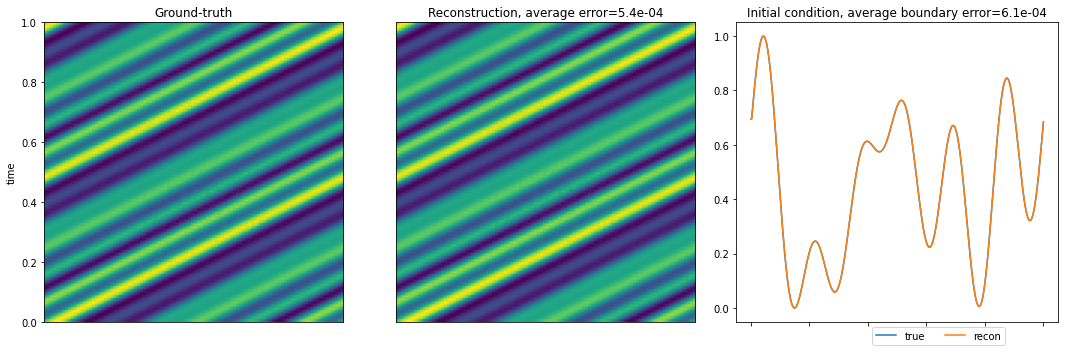

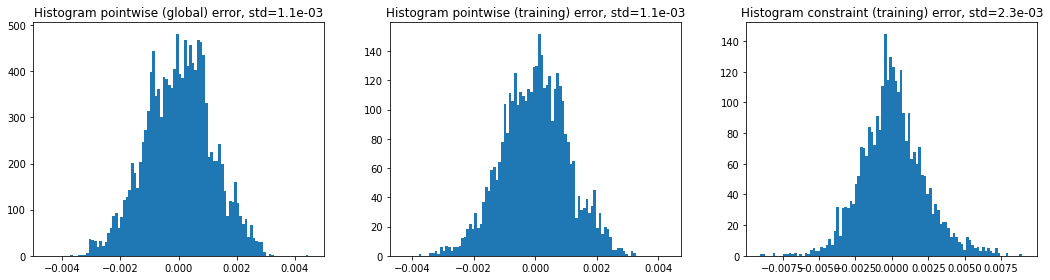

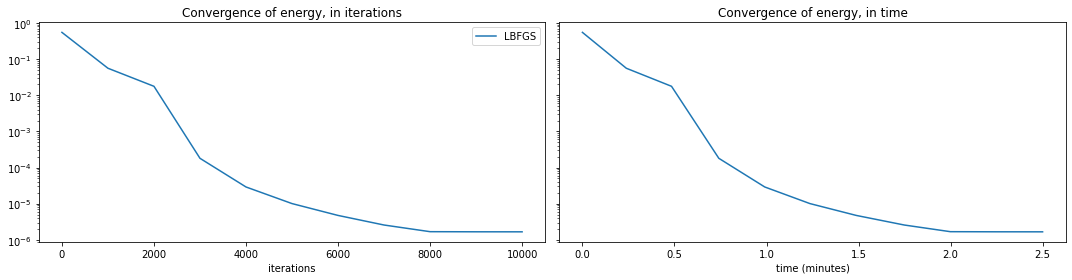

In [ ]:
#@title Single example of PINN reconstruction
# The first parameter should either be 'advection-periodic' or 'heat' depending 
# on which pde to use.
# Change i between 0 and 1999 to get a different example, i=None will give a 
# new random example each time.
M, tx, u, eu, ef, t = randomExample('advection-periodic', layers=[60]*4,
                            optimise=(
                                (0e3,'Adam',{'threshold':1e-3},{'lr':1e-3}),
                                (1e4,'LBFGS',{},{}),
                            ), i=10, Nint=3000)

plt.figure(figsize=(15,5))
plotcompare2d(tx, u, M.predict(tx)[:,0])
plt.tight_layout()

_, ax = plt.subplots(1, 3, figsize=(15, 4))
for i, (arr,s) in enumerate([(M.predict(tx)[:,0]-u,'pointwise (global)'),
                            (eu,'pointwise (training)'),
                            (ef,'constraint (training)')]):
    ax[i].hist(arr,range=[-4*arr.std(),4*arr.std()],bins=100)
    ax[i].set_title('Histogram %s error, std=%.1e'%(s,arr.std()))
plt.tight_layout()

plotHistory(M,plt.figure(figsize=(15,4)))

# Fitting lots of PDEs
- Test the same network on 200 random PDEs
- Half of the tests will be on the heat equation ($\partial_t u - \partial_{xx} u = 0$), half advection ($\partial_t u + \partial_x u = 0$)

In [ ]:
#@title Run all examples
Ntest = 100
UA, VA, x, perfA = PINNbatchrecon('heat', Ntest,layers=[60]*4, load=True, Nint=3000,
                        optimise=(
                            (1e4,'Adam',{'threshold':1e-2},{'lr':1e-3}),
                            (1e4,'LBFGS',{},{'tolerance_change':1e-15}),
                        ))
UH, VH, x, perfH = PINNbatchrecon('advection-periodic', Ntest,layers=[60]*4, load=True, Nint=3000,
                        optimise=(
                            (1e4,'Adam',{'threshold':1e-3},{'lr':1e-3}),
                            (1e4,'LBFGS',{},{'tolerance_change':1e-15}),
                        ))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

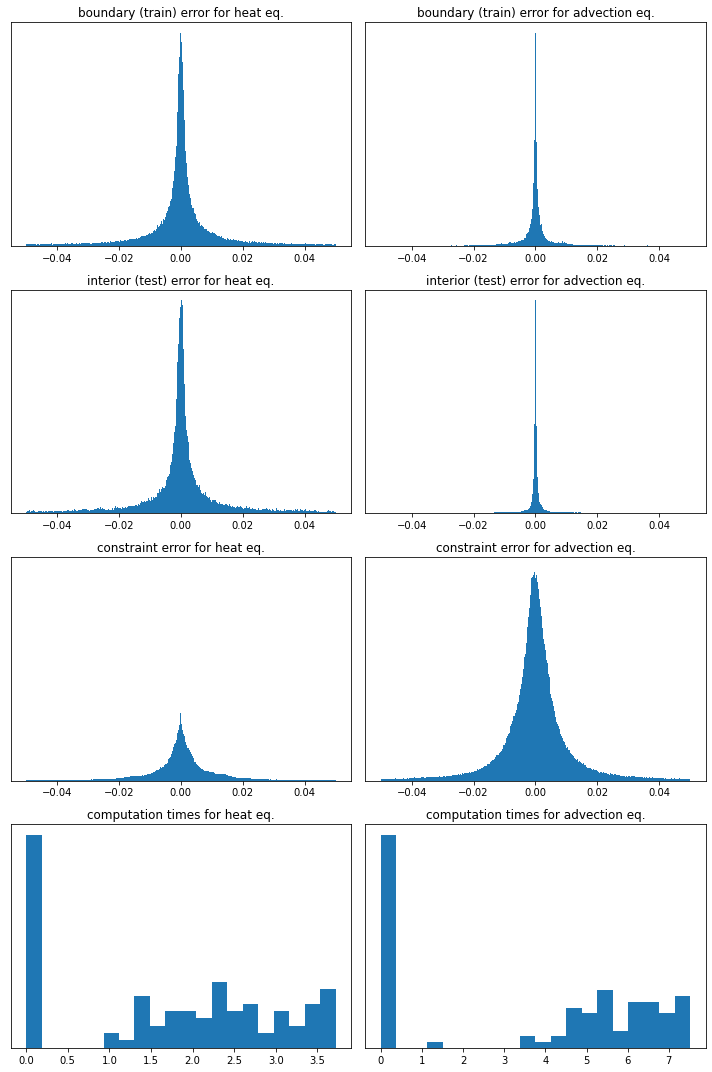

In [ ]:
#@title Plot errors
_, ax = plt.subplots(4,2,figsize=(10,15),sharex=False)
for i,s in enumerate(('heat','advection')):
    ax[0,i].set_title('Convergence for %s equation'%s)
for i,(k,s) in enumerate((('eb','boundary (train) error'),
                          ('ei','interior (test) error'),
                          ('ep','constraint error'),
                          ('toc','computation times'))):
    for j in range(2):
        arr = (perfA if j else perfH)[k].ravel()
        if k=='toc':
            nbins = 20
            rng = [0,arr.max()]
        else:
            nbins = 1000
            rng = [-0.05,0.05]
        ax[i,j].hist(arr, nbins, range=rng)
        ax[i,j].set_yticks([])
        ax[i,j].set_ylim(None)
    ax[i,0].set_title(s+' for heat eq.')
    ax[i,1].set_title(s+' for advection eq.')
plt.tight_layout()

# Next step, fitting a whole image

  0%|          | 0/10000 [00:00<?, ?it/s]

Starting loss: 4.720e-02, End loss: 6.843e-04, Iterations: 10000, Time:  1.4m


  0%|          | 0/10000 [00:00<?, ?it/s]

Starting loss: 6.843e-04, End loss: 1.176e-04, Iterations: 10000, Time:  2.4m


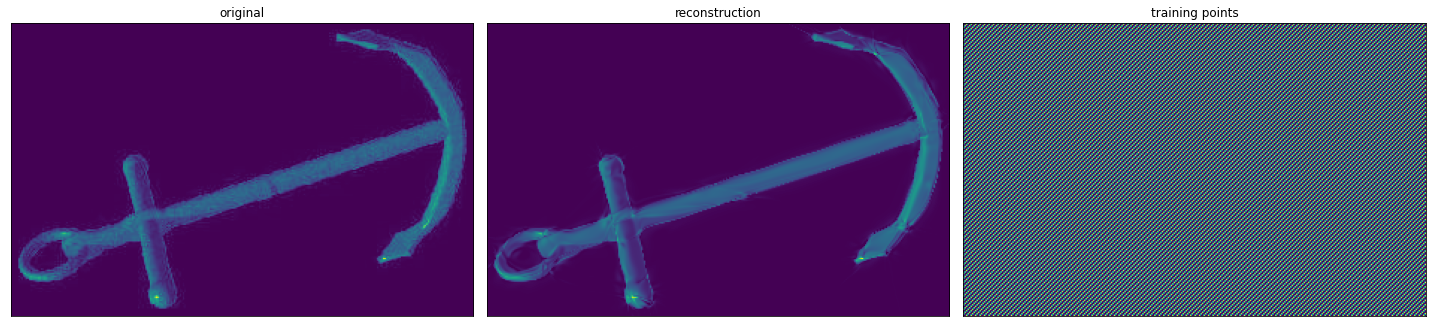

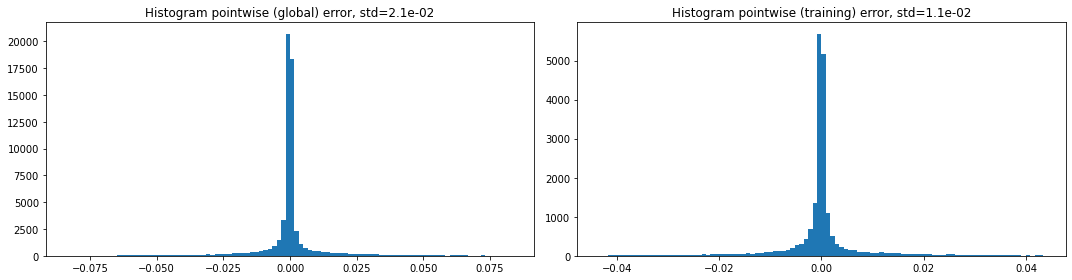

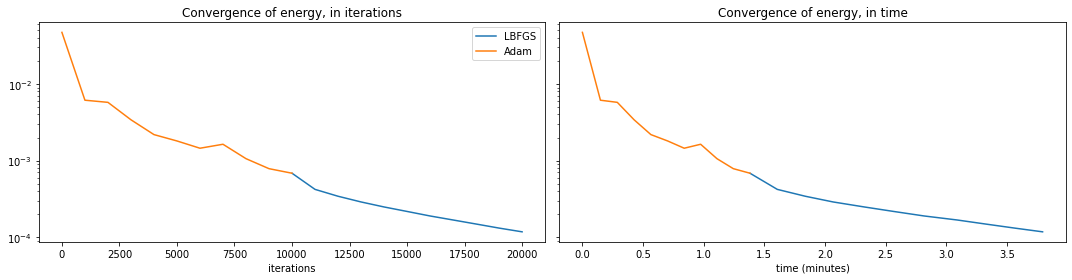

In [ ]:
#@title Fitting image with PINN
xy = np.mgrid[:myImg.shape[0], :myImg.shape[1]]
xy = np.concatenate([z.reshape(-1, 1) for z in xy], axis=1) / min(myImg.shape)
xy_train = np.zeros(xy.shape[0], dtype=bool)
xy_train[::3] = True # only use 1/3 points for training

threshold = 1e-5
M = PINNrun(xy[xy_train], myImg.ravel()[xy_train], 
            np.zeros((0,2)), lambda X,u:0.0, 
            layers=[50]*6, activation='tanh', load=None,
            optimise=((1e4,'Adam',{'threshold':threshold}), (1e4,'LBFGS')))

img = M.predict(xy).reshape(myImg.shape)

_, ax = plt.subplots(1, 3, figsize=(20, 7))
for i, (arr,s) in enumerate(((myImg,'original'),(img,'reconstruction'),
                             (xy_train.reshape(myImg.shape),'training points'))):
    ax[i].imshow(arr,vmin=0,vmax=1)
    ax[i].set_xticks([]); ax[i].set_yticks([])
    ax[i].set_title(s)
plt.tight_layout()

_, ax = plt.subplots(1, 2, figsize=(15, 4))
for i, (arr,s) in enumerate([((myImg-img).ravel(),'pointwise (global)'),
                            ((myImg-img).ravel()[xy_train],'pointwise (training)')]):
    ax[i].hist(arr,range=[-4*arr.std(),4*arr.std()],bins=100)
    ax[i].set_title('Histogram %s error, std=%.1e'%(s,arr.std()))
plt.tight_layout()

plotHistory(M,plt.figure(figsize=(15,4)),threshold)

# Non-trivial example
We now consider the curvature-flow:
$$ \partial_t u = |\nabla_{x,y} u|\kappa(u)^{\frac13} = (\partial_yu^2 \partial_{xx}u - 2\partial_xu \partial_yu \partial_{xy}u + \partial_xu^2 \partial_{yy}u)^{\frac13}
$$
with initial condition $u(0,x,y) = \operatorname{myImg}$.

The challenge with this PDE is that it is relatively difficult to implement stably with finite differences, the hope is that the PINN will overcome these difficulties implicitly.

The comparison is therefore 3-way:
- There is an 'advanced' reconstruction which uses the finite difference scheme from the [megawave](https://github.com/nilx/megawave/blob/d3cd6b8152d4933b563ac224a123583335180436/src/image/filter/amss.c) package. This is assumed to be a ground-truth.
- There is a 'basic' reconstruction which uses my naive finite difference implementation
- Finally, we compare against a PINN

In [ ]:
#@title Utility functions for curvature flow

@jit(nopython=True, boundscheck=False, cache=True)
def pointwiseFancyRHS(u, threshold):
    ''' u.shape = (3,3), threshold = float
    returns |Du| k(u)^1/3 = (u_y^2 u_xx - 2u_x u_y u_xy + u_x^2 u_yy) ^ (1/3) 
    Note 0.353553391 = 1/sqrt(8)
    '''
    u_x = u[2, 1] - u[0, 1] + (0.353553391) * (u[2, 2] + u[2, 0] - u[0, 2] - u[0, 0])
    u_y = u[1, 2] - u[1, 0] + (0.353553391) * (u[2, 2] + u[0, 2] - u[2, 0] - u[0, 0])

    u_x, u_xy, u_y = u_x**2, u_x * u_y, u_y**2
    norm2 = u_x + u_y

    if norm2 < threshold:
        return 0.0
    else:
        u_x /= norm2; u_xy /= norm2; u_y /= norm2
        L0 = 0.5 - u_xy**2
        GK = (
            (-4 * L0) * u[1, 1]
            + (2 * L0 - u_x) * (u[0, 1] + u[2, 1])
            + (2 * L0 - u_y) * (u[1, 0] + u[1, 2])
            + (-L0 + .5 * (u_x + u_y - u_xy)) * (u[2, 2] + u[0, 0])  # u_x+u_y=1?
            + (-L0 + .5 * (u_x + u_y + u_xy)) * (u[0, 2] + u[2, 0])  # u_x+u_y=1?
        )
        # Apparently |Du|k^1/3 = (|Du|^2GK/dx^2)^1/3. This is wrong, they both have different units...
        return np.cbrt(GK * (norm2 * 0.0857864376))  # 0.0857864376 = (2+sqrt(2))^-2


@jit(nopython=True, boundscheck=False, cache=True, parallel=True)
def doFancystep(un, unp1, dt):
    threshold = 1e-10
    for i in prange(un.shape[0]):
        im, ip = int(max(i - 1, 0)), int(min(i + 1, un.shape[0] - 1))
        buf = np.empty((3, 3), dtype='float32')

        j = 0
        buf[0, 0], buf[0, 1], buf[0, 2] = un[im, 0], un[im, 0], un[im, 1]
        buf[1, 0], buf[1, 1], buf[1, 2] = un[i, 0], un[i, 0], un[i, 1]
        buf[2, 0], buf[2, 1], buf[2, 2] = un[ip, 0], un[ip, 0], un[ip, 1]
        unp1[i, j] = un[i, j] + dt * pointwiseFancyRHS(buf, threshold)

        j += 1
        while j < un.shape[1] - 1:
            buf[:, :2] = buf[:, 1:]
            buf[0, 2], buf[1, 2], buf[2, 2] = un[im, j + 1], un[i, j + 1], un[ip, j + 1]
            # buf[0, 0], buf[0, 1], buf[0, 2] = un[im, j - 1], un[im, j], un[im, j + 1]
            # buf[1, 0], buf[1, 1], buf[1, 2] = un[i, j - 1], un[i, j], un[i, j + 1]
            # buf[2, 0], buf[2, 1], buf[2, 2] = un[ip, j - 1], un[ip, j], un[ip, j + 1]
            unp1[i, j] = un[i, j] + dt * pointwiseFancyRHS(buf, threshold)
            j += 1

        buf[:, :2] = buf[:, 1:]  # buf[:, 2] stays the same
        unp1[i, j] = un[i, j] + dt * pointwiseFancyRHS(buf, threshold)

@jit(nopython=True, boundscheck=False, cache=True)
def pointwiseLazyRHS(u, threshold):
    ''' u.shape = (3,3), threshold = float
    returns |Du| k(u)^1/3 = (u_y^2 u_xx - 2u_x u_y u_xy + u_x^2 u_yy) ^ (1/3) 
    '''
    u_x = .5*(u[2, 1] - u[0, 1])
    u_y = .5*(u[1, 2] - u[1, 0])
    u_xx = u[2,1] - 2*u[1,1] + u[0, 1]
    u_yy = u[1,2] - 2*u[1,1] + u[1, 0]
    u_xy = .25*(u[2,2] - u[2,0] - u[0,2] + u[0,0])

    return np.cbrt(u_y**2*u_xx - 2*u_x*u_y*u_xy + u_x**2*u_yy)
    

@jit(nopython=True, boundscheck=False, cache=True, parallel=True)
def doLazystep(un, unp1, dt):
    threshold = 1e-10
    for i in prange(un.shape[0]):
        im, ip = int(max(i - 1, 0)), int(min(i + 1, un.shape[0] - 1))
        buf = np.empty((3, 3), dtype='float32')

        j = 0
        buf[0, 0], buf[0, 1], buf[0, 2] = un[im, 0], un[im, 0], un[im, 1]
        buf[1, 0], buf[1, 1], buf[1, 2] = un[i, 0], un[i, 0], un[i, 1]
        buf[2, 0], buf[2, 1], buf[2, 2] = un[ip, 0], un[ip, 0], un[ip, 1]
        unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)

        j += 1
        while j < un.shape[1] - 1:
            buf[:, :2] = buf[:, 1:]
            buf[0, 2], buf[1, 2], buf[2, 2] = un[im, j + 1], un[i, j + 1], un[ip, j + 1]
            # buf[0, 0], buf[0, 1], buf[0, 2] = un[im, j - 1], un[im, j], un[im, j + 1]
            # buf[1, 0], buf[1, 1], buf[1, 2] = un[i, j - 1], un[i, j], un[i, j + 1]
            # buf[2, 0], buf[2, 1], buf[2, 2] = un[ip, j - 1], un[ip, j], un[ip, j + 1]
            unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)
            j += 1

        buf[:, :2] = buf[:, 1:]  # buf[:, 2] stays the same
        unp1[i, j] = un[i, j] + dt * pointwiseLazyRHS(buf, threshold)


def computeFlow(u, dx, dt, Tmax, frames, version='fancy'):
    step = doFancystep if version=='fancy' else doLazystep
    U = [u[None].copy()]
    u, v = u.copy(), u.copy()
    frame, frames = 1, np.linspace(0, Tmax, frames)

    # Very lazy hack to get minimal arange with T[-1]>=Tmax
    T = np.arange(0,Tmax+2*dt,dt)[1:]
    while T[-2]>=Tmax:
        T = T[:-1]

    for t in tqdm(T):
        step(u, v, dt / dx**(4 / 3))
        if t >= frames[frame]:
            U.append(v[None].copy())
            frame += 1
        u, v = v, u
    return u, frames, np.concatenate(U, axis=0)


def curvature_pde(X, u):  # X[i] = (t, x, y)
    # returns u_t^3 - |Du|^3 k(u) = u_t^3 - (u_y^2 u_xx - 2u_x u_y u_xy + u_x^2 u_yy)
    if X.shape[0] == 0:
        return pt.tensor(0.0)
    U = u(X)
    dU = pt.autograd.grad(U, X,  # first derivative
                          grad_outputs=pt.ones_like(U),
                          retain_graph=True,
                          create_graph=True)[0]
    U_t, U_x, U_y = dU[:, [0]], dU[:, [1]], dU[:, [2]]
    dU_x = pt.autograd.grad(U_x, X,  # second derivative
                            grad_outputs=pt.ones_like(U_x),
                            retain_graph=True,
                            create_graph=True)[0]
    U_xx, U_xy = dU_x[:, [1]], dU_x[:, [2]]
    U_yy = pt.autograd.grad(U_y, X,  # second derivative
                            grad_outputs=pt.ones_like(U_y),
                            retain_graph=True,
                            create_graph=True)[0][:, [2]]
    return U_t**3 - (U_y**2 * U_xx - 2 * U_x * U_y * U_xy + U_x**2 * U_yy)
    # return U_t - pt.pow(U_y**2 * U_xx - 2 * U_x * U_y * U_xy + U_x**2 * U_yy, 1/3)

def CurvatureRun(u, dx, Tmax, frames, interior=1e5, layers=[50] * 4, **kwargs):
    # Top corner of bounding box of domain
    sz = u.shape
    box = (Tmax, (sz[0] - 1) * dx, (sz[1] - 1) * dx)

    # Choose boundary points:
    S = np.mgrid[:1, :sz[0], :sz[1]]  # S = slice at time=0
    S = np.concatenate([x.reshape(-1, 1) for x in S], axis=1) * dx
    X, u = S, u.ravel()  # only fit t=0 slice
    X, u = X[::9], u[::9] # only fit to some of the initial array

    # Choose random interior points:
    interior = np.random.rand(int(interior), X.shape[1]) * np.array([box])

    model = PINNrun(X, u, interior, curvature_pde, layers=layers, **kwargs)
    frames = np.linspace(0, box[0], frames)

    return model, frames, np.concatenate([model.predict(S + np.array([[t, 0, 0]])).reshape(1, *sz) for t in frames], axis=0)

  0%|          | 0/20000 [00:00<?, ?it/s]

                                                  Ground-truth flow from advanced FD implementation


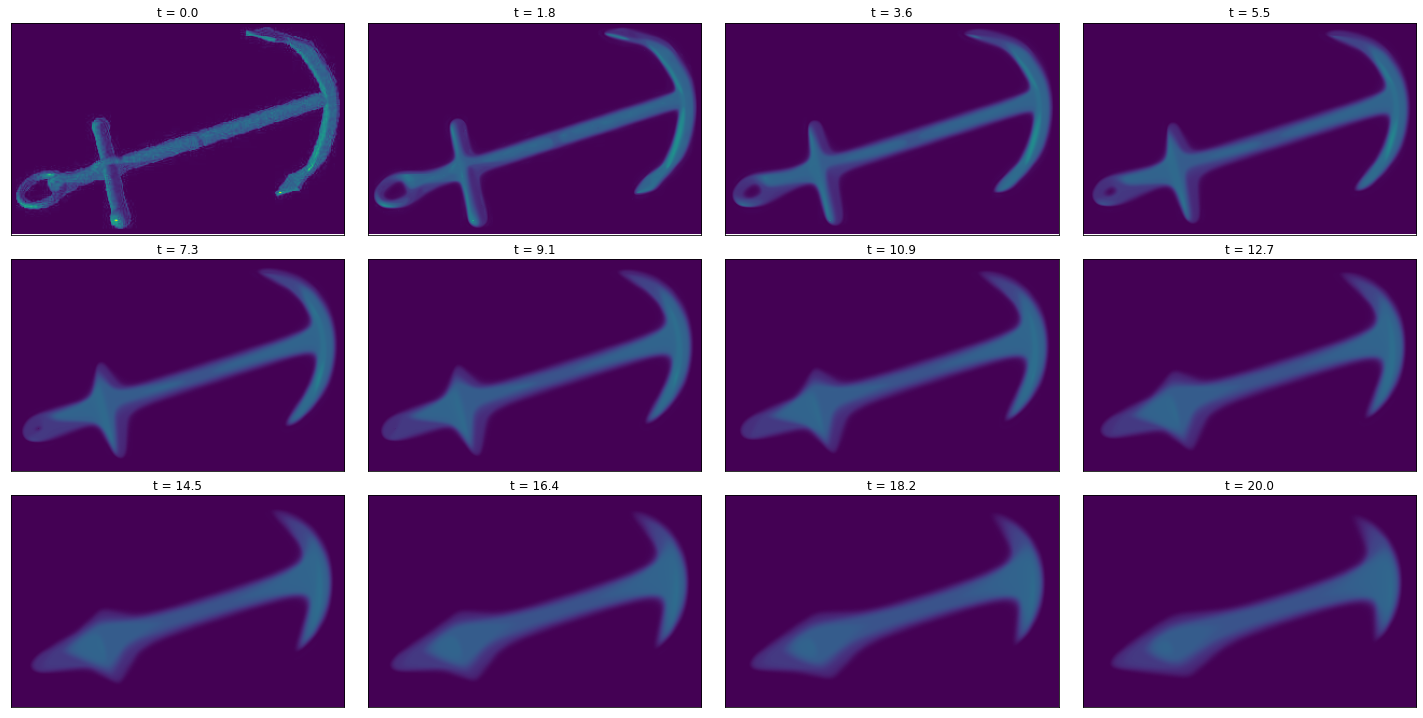

In [ ]:
#@title Computing flow with advanced finite differences
ops = {'dx':100/min(myImg.shape), 'Tmax':20, 'frames':12}
u_gt, t, U = computeFlow(myImg, dt=1e-3, **ops)
print(' '*50 + 'Ground-truth flow from advanced FD implementation')
_, ax = plt.subplots(3,4,figsize=(20,10))
for i in range(len(t)):
    plt.sca(ax.item(i))
    plt.imshow(U[i],vmin=0,vmax=1)
    plt.xticks([]); plt.yticks([]); plt.title('t = %.1f'%t[i])
plt.tight_layout()

  0%|          | 0/20000 [00:00<?, ?it/s]

Errors: average=0.001, std=0.003, max=0.035


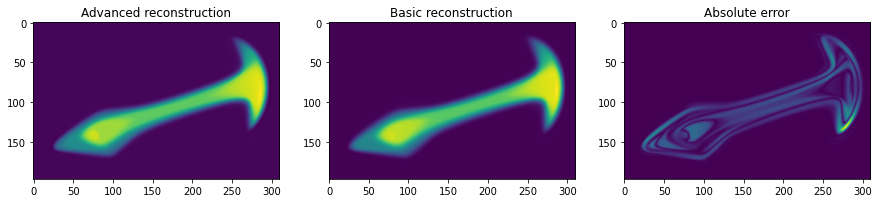

In [ ]:
#@title Computing flow with basic finite differences
u_lazy, t, U = computeFlow(myImg, dt=1e-3, version='lazy', **ops)
plt.figure(figsize=(15,3))
plt.subplot(131).imshow(u_gt); plt.title('Advanced reconstruction')
plt.subplot(132).imshow(u_lazy); plt.title('Basic reconstruction')
tmp = abs(u_gt-u_lazy)
plt.subplot(133).imshow(tmp); plt.title('Absolute error')
print('Errors: average=%.3f, std=%.3f, max=%.3f'%(tmp.mean(), tmp.std(), tmp.max()))

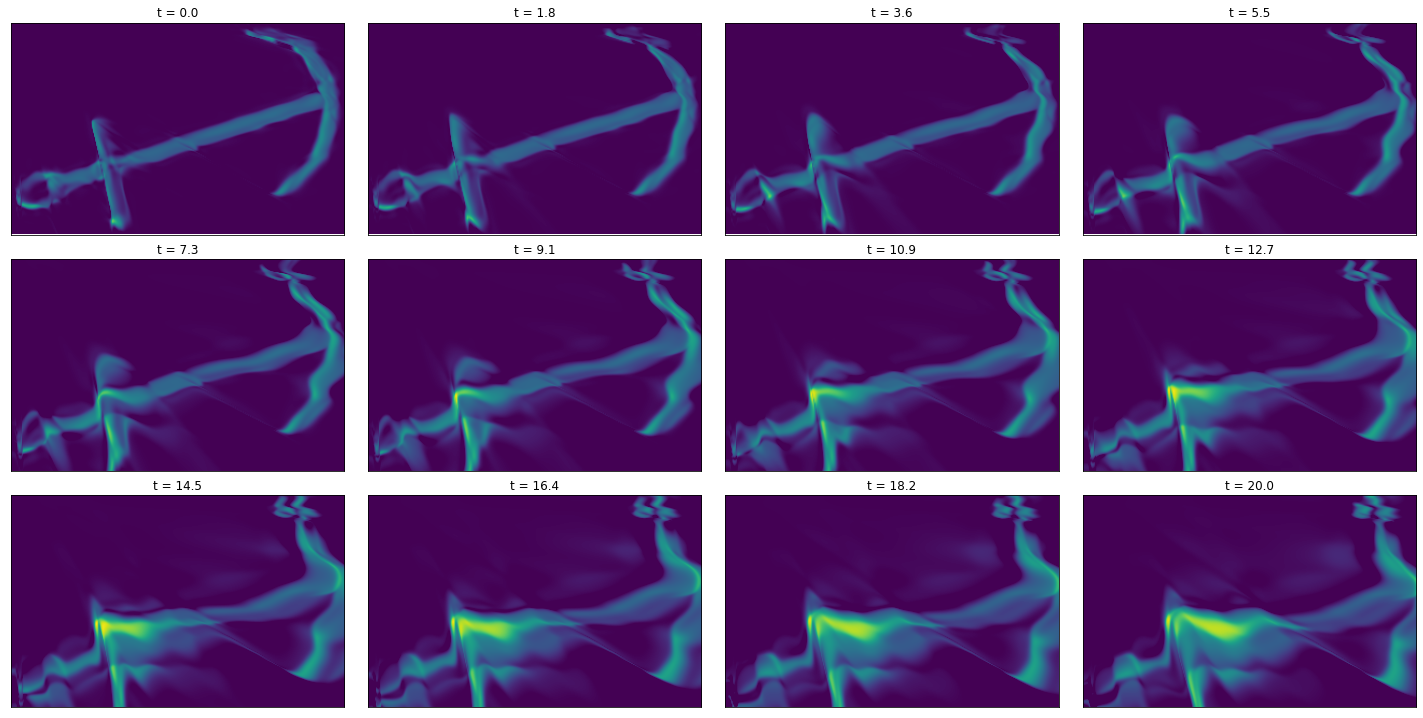

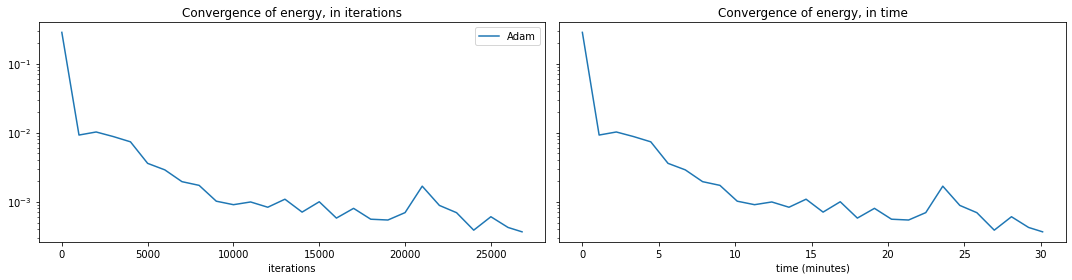

In [ ]:
#@title PINN curvature flow reconstruction (constraining to 30 minutes training)
M, t, U = CurvatureRun(myImg, **ops, layers=[60]*5, interior=1e4,
        load=('models','anchor-curvature'),
        optimise=(
            (3e4,'Adam',{'threshold':2e-4},{'lr':1e-3}),
            (0e4,'LBFGS',{},{'tolerance_change':1e-15}),
        )
)

_, ax = plt.subplots(3,4,figsize=(20,10))
for i in range(len(t)):
    plt.sca(ax.item(i))
    plt.imshow(U[i],vmin=0,vmax=1)
    plt.xticks([]); plt.yticks([]); plt.title('t = %.1f'%t[i])
plt.tight_layout()

plotHistory(M,plt.figure(figsize=(15,4)))

## Extra 
- Recurrent NN (e.g. LSTM) structures are good for dynamic problems 
- Low frequency information is in early layers and is learned first [link](https://www.frontiersin.org/articles/10.3389/fdata.2021.669097/full)
- ResNet-like block improves stability [link](https://www.mdpi.com/2073-4441/13/4/423/htm)
- Some use finite differences instead of automatic differentiation [link](https://ieeexplore.ieee.org/document/9403414) 
- PINN overcomes curse of dimensionality [link](https://www.sciencedirect.com/science/article/pii/S0022407321001989?via%3Dihub)
- Sin activation is more stable than tanh [link](https://maziarraissi.github.io/research/09_hidden_fluid_mechanics/)
- PINN is better than fast-sweeping [link](https://arxiv.org/pdf/2007.08330.pdf)
- PINN is superior to typical discretisations [link](https://arxiv.org/pdf/2012.11658v1.pdf)

---

## Final comments
- If you just run the examples you see in papers then PINNs look great. They can be very efficient (in time and memory) at getting good looking solutions to PDEs
- I've found it hard to go beyond around $10^{-2}$ average error, other papers might have $10^{-6}$, classical methods should be used to go beyond this
- Whenever I've seen 'state of the art performance' for a PINN vs classical, it's accompanied by an embarrassing amount of computation time
- I think the biggest advantage of Vanilla PINNs is where you can only evaluate your PDE in a few places (for example when a coefficient of the PDE needs to be physically measured). If you expect your solution to be 'nice and smooth', NNs with tanh activations give a very interpolation. I've never really liked the look of finite elements on coarse grids. Also, it doesn't make sense to solve the PDE constraint to machine precision if you only have a coarse approximation of it.
- The hardest part of PINNs for me was the training. There is a magic balance of layers and number of training points where you can get very good results very quickly. For example, changing the number of interior points (up or down) in the `Single example of PINN reconstruction` greatly changes the convergence:
    - For `Nint=3000` (the default) it converges nicely in 6000 iterations (although for some random network initialisations I have still seen it fail to even start...)
    - The reconstruction is the same with only `Nint=300`, there is no decrease in generalisation error after rounding
    - If you drop to `Nint=100`, then the network fails to fit either the PDE or boundary condition, even after the full 10000 iterations
    - If I increase to just `Nint=4000`, then LBFGS seems to fail to escape the initial saddle point around 50% of the time
- On a related point, I am sure that my failure to find a good curvature-flow PINN solution is mine and not the method. A better choice of layers and more optimisation time will surely perform well. The point is that, outside the perfect examples we see in papers, it is hard to immediately adapt to my own problem.
- Higher order derivatives take a long time to compute via automatic differentiation, consider using one of the 'weak formulation' variants if you have a $>$ second order equation
- One selling point of PINNs is that we can exchange PDE expertise for ML expertise. For such simple PDEs as in this document one can probably take this to the complete extreme. In more complicated problems with stiffness/shocks, the choice of collocation points becomes critical, requiring PDE expertise to overcome. I guess in the future we will have big black-box PINN-PDE libraries, like for finite elements, written by a combination of programers and PDE experts.